# Maximum Likelihood Estimation algorithm

This script is a example of the Maximum Likelihood Estimation algorithm for energy disaggregation. 

It is liable when a single disaggregated appliance is desired instead of disaggregating many. Beside, the appliance should be mostly resistive to achieve accuracy. 

It is based on paired Events: 
    - OnPower: delta value when the appliance is turned on.
    - OffPOwer: delta value when the appliance is turned off.
    - Duration: duration between onpower and offpower. 
    
Also, to discard many unlikely events, three constrains are set: 
    - PowerNoise: mininum delta value below which the delta is considered noise.
    - PowerPair: maximum difference between OnPower and OffPower (considering appliances with constans energy consumption). 
    - timeWindow: maximum time frame between Onpower and Offpower. 
    
Features aforementioned are modeled with Gaussian, Gaussian Mixtures or Poisson. For each incoming paired event, the algorithm will extract these three features and will evaluate the maximum likelihood probability for that paired event of being a certain appliance. 


#### IMPORTS

In [40]:
import numpy as np
import pandas as pd
from os.path import join
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = (13, 6)
#plt.style.use('ggplot')
from datetime import datetime as datetime2
from datetime import timedelta

import nilmtk
from nilmtk.disaggregate.maximum_likelihood_estimation import MLE
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from scipy.stats import poisson, norm
from sklearn import mixture
import warnings
warnings.filterwarnings("ignore")

#### Functions 

In [41]:
def get_all_appliances(appliance):

    # Filtering by appliances: 
    print "Fetching " + appliance + " over data loaded to nilmtk."
    metergroup = nilmtk.global_meter_group.select_using_appliances(type=appliance)
    
    if len(metergroup.appliances) == 0: 
        print "None " + appliance + " found on memory."
        pass

    # Selecting only single meters: 
    print "Filtering to get one meter for each " + appliance

    meters = [meter for meter in metergroup.meters if (len(meter.appliances) == 1)]
    metergroup = MeterGroup(meters)
    print metergroup
    print "Found " + str(len(metergroup.meters)) + " " + appliance

    return metergroup


def get_all_trainings(appliance, train):

    # Filtering by appliances: 
    print "Fetching " + appliance + " over data train data."
    elecs = []
    for building in train.buildings: 
        print "Building " + str(building) + "..."
        elec = train.buildings[building].elec[appliance]
        if len(elec.appliances) == 1: 
            print elec
            print "Fetched elec."
            elecs.append(elec)

        else: 
            print elec
            print "Groundtruth does not exist. Many appliances or None"

    metergroup = MeterGroup(elecs)

    return metergroup

## Loading data 

In [42]:
path = '../../../nilmtk/data/ukdale'
ukdale = train = DataSet(join(path, 'ukdale.h5'))

And spliting into train and test data

In [43]:
train = DataSet(join(path, 'ukdale.h5'))
test = DataSet(join(path, 'ukdale.h5'))
train.set_window(end="17-5-2013")
test.set_window(start="17-5-2013")
#zoom.set_window(start="17-5-2013")
print('loaded ' + str(len(ukdale.buildings)) + ' buildings')

loaded 5 buildings


### Getting the training data

The selected appliance might not be trained from ElecMeters where other appliances are presented as we can extract the groundtruth

In [44]:
# Appliance to disaggregate: 
applianceName = 'kettle'
# Groundtruth from the training data: 
metergroup = get_all_trainings(applianceName,train)

Fetching kettle over data train data.
Building 1...
ElecMeter(instance=10, building=1, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1), Appliance(type='food processor', instance=1), Appliance(type='toasted sandwich maker', instance=1)])
Groundtruth does not exist. Many appliances or None
Building 2...
ElecMeter(instance=8, building=2, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])
Fetched elec.
Building 3...
ElecMeter(instance=2, building=3, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])
Fetched elec.
Building 4...
ElecMeter(instance=3, building=4, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1), Appliance(type='radio', instance=1)])
Groundtruth does not exist. Many appliances or None
Building 5...
ElecMeter(instance=18, building=5, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])
Fetched elec.


## MLE algorithm 

### Training  

First, we create the model

In [45]:
 mle = MLE()

Then, we update the model parameter with some guessing values. 

First guess for features: onpower and offpower gaussian mixtures and duration poisson. 

In [46]:
# setting parameters in the model: 
mle.update(appliance=applianceName, resistive=True, units=('power','active'), thDelta= 1500, thLikelihood= 1e-10, powerNoise= 50, powerPair= 100, timeWindow= 400, sample_period= '10S', sampling_method='first')

# Settings the features parameters by guessing:  
mle.onpower = {'name':'gmm', 'model': mixture.GMM(n_components=2)}
mle.offpower = {'name':'gmm', 'model': mixture.GMM(n_components=2)}
mle.duration = {'name':'poisson', 'model': poisson(0)}

Updating model
{'resistive': True, 'appliance': 'kettle', 'sampling_method': 'first', 'sample_period': '10S', 'thLikelihood': 1e-10, 'timeWindow': 400, 'units': ('power', 'active'), 'thDelta': 1500, 'powerNoise': 50, 'powerPair': 100}


####  Training the model

We train the model with all ocurrences of that model of appliance found on the training data

In [47]:
mle.train(metergroup)

('kettle', 1)
Training on chunk
Samples of onpower: 214
Samples of offpower: 214
Samples of duration: 214
Training onpower
Training offpower
Training duration
('kettle', 2)
Training on chunk
Samples of onpower: 92
Samples of offpower: 92
Samples of duration: 92
Training onpower
Training offpower
Training duration
('kettle', 3)
Chunk empty


And then we visualize features with featureHist_colors() to see the distribution and how many samples we have for each appliance (same model from different houses). 

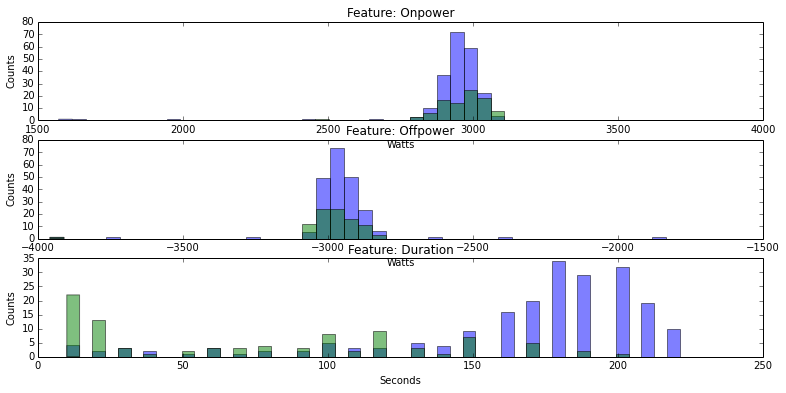

In [49]:
mle.featuresHist_colors()

Sometimes, we have more events from some houses than others, as we see on the figure above. Therefore, we need to crop information to keep the same number of samples for everyhouse. 

In [50]:
mle.no_overfitting()

Retraining onpower
Retraining offpower
Retraining duration


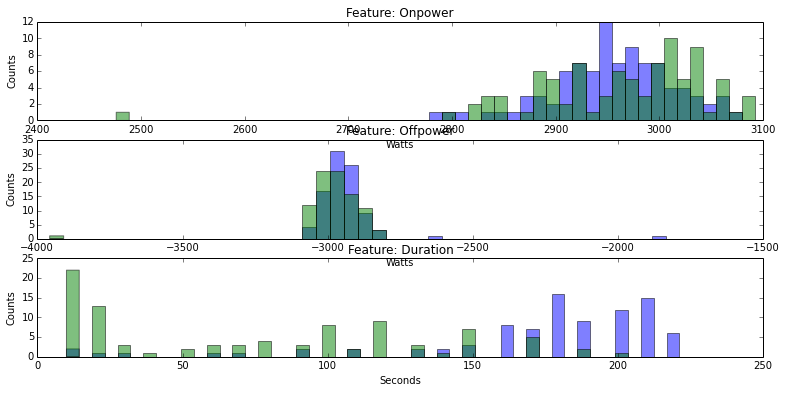

In [51]:
mle.featuresHist_colors()

There is another visualization tool to see how model distributions fit over the data: 

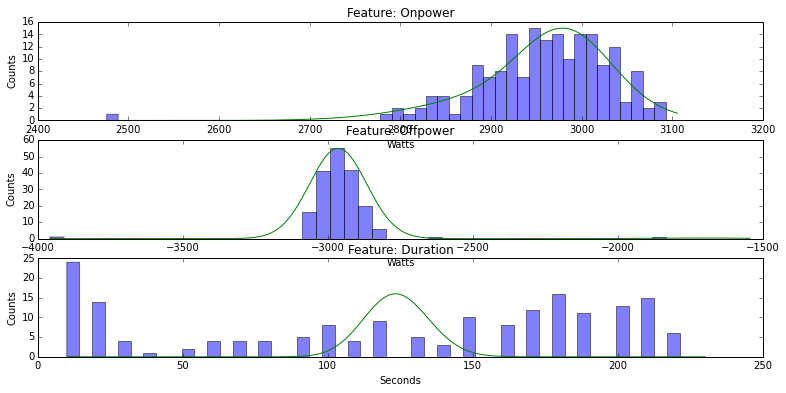

In [52]:
mle.featuresHist()

Onpower and Offpower seem to fit well with the data but we need to change the model for duration

In [53]:
mle.duration = {'name':'gmm', 'model': mixture.GMM(n_components=10)}

And then we retrain the model and use no_overfitting

('kettle', 1)
Training on chunk
Samples of onpower: 214
Samples of offpower: 214
Samples of duration: 214
Training onpower
Training offpower
Training duration
('kettle', 2)
Training on chunk
Samples of onpower: 92
Samples of offpower: 92
Samples of duration: 92
Training onpower
Training offpower
Training duration
('kettle', 3)
Chunk empty
Retraining onpower
Retraining offpower
Retraining duration


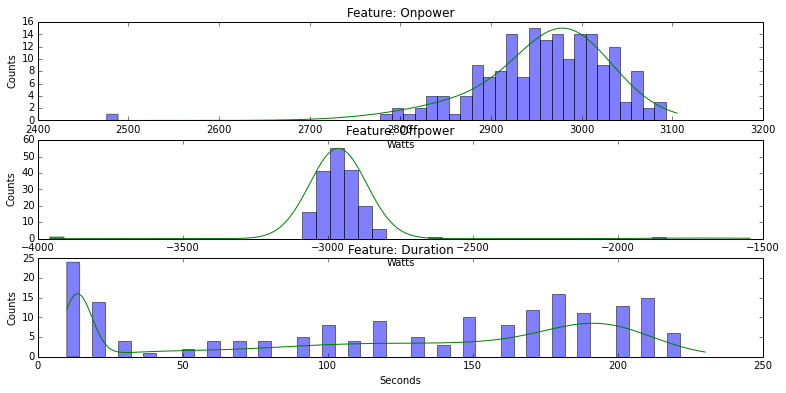

In [54]:
mle.train(metergroup)
mle.no_overfitting()
mle.featuresHist()

Once we have the final model distribution for each feature. We need to the integrity of each distribution. Each CDF has to be bounded by one. 

In [55]:
mle.check_cdfIntegrity(step=10)

Onpower cdf: 0.986177684776
Offpower cdf: 1.0
Duration cdf: 0.987370844967


### Testing 